In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from scipy.stats import multivariate_normal as sp_mvnorm
from scipy.stats import norm

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
from tqdm import tqdm
import pandas as pd
import datetime

import pickle
import jax
import cvxpy as cvx

In [4]:
from aaai_helpers.optim import *
from aaai_helpers.eval import *
from aaai_helpers.jax_spm import *
from aaai_helpers.baselines import *
from aaai_helpers.plots import *
from aaai_helpers.utils import *

Private data

In [8]:
with open('priv_data_2d_70d_3pols.pickle', 'rb') as f:
    priv_data = pickle.load(f)

In [13]:
mu_0_train = priv_data['train']['mu']
cov_0_train = priv_data['train']['cov']

mu_0_test = priv_data['test']['mu']
cov_0_test = priv_data['test']['cov']

nbucket, npol = mu_0_train.shape[:-1]

In [17]:
ref_col = 0

total_v_ref_train = np.sum(np.array(mu_0_train[:,:,0])[:,ref_col])
total_c_ref_train = np.sum(np.array(mu_0_test[:,:,-1])[:,ref_col])

total_v_ref_test = np.sum(np.array(mu_0_train[:,:,0])[:,ref_col])
total_c_ref_test = np.sum(np.array(mu_0_test[:,:,-1])[:,ref_col])

In [24]:
### Define r_v (success region) with AB test interpretation
r_v_pct_range = np.arange(0, 0.021, 0.001)
R_vs_train = r_v_pct_range ### rel diff
R_vs_test = r_v_pct_range ### rel diff

methods = ['Bruteforce', 'LinProg', 'MixedInt', 'SuccessProbaMax']
res_v_2d_train = {i:np.zeros_like(R_vs_train) for i in methods}
res_v_2d_test = {i:np.zeros_like(R_vs_test) for i in methods}

In [25]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = np.array(list(itertools.product(candidates, repeat=nbucket)))[:-1] ### avoid all refs as it raise singular matrix

### psi_0s for SuccessProbaMax
psi_0s = jnp.array([random.dirichlet(random.PRNGKey(i*23563), np.ones(npol), shape=(nbucket,)) for i in range(50000)])

In [28]:
for i in tqdm(range(len(R_vs_train))):
    hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0_train, cov_0_train, R_vs_train[i], total_c_ref_train)
    res_v_2d_train['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_train, cov_0_train, R_vs_train[i], total_c_ref_train)
    res_v_2d_test['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_test, cov_0_test, R_vs_test[i], total_c_ref_test)
    
    greedy_soft_alloc = greedy_2d(mu_0_train[:,:,0], mu_0_train[:,:,-1], total_c_ref_train, nbucket, npol)
    res_v_2d_train['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_train, cov_0_train, R_vs_train[i], total_c_ref_train)
    res_v_2d_test['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_test, cov_0_test, R_vs_test[i], total_c_ref_test)
    
    greedy_mi_alloc = greedy_2d(mu_0_train[:,:,0], mu_0_train[:,:,-1], total_c_ref_train, nbucket, npol, soft=0)
    res_v_2d_train['MixedInt'][i] = evaluate_2d_v2(greedy_mi_alloc, mu_0_train, cov_0_train, R_vs_train[i], total_c_ref_train)
    res_v_2d_test['MixedInt'][i] = evaluate_2d_v2(greedy_mi_alloc, mu_0_test, cov_0_test, R_vs_test[i], total_c_ref_test)
    
    spm_alloc = optimize_2d_my_v4(cov_0_train, mu_0_train, R_vs_train[i], total_c_ref_train, psi_0s, n_steps=5000000, eta = 0.0001)
    res_v_2d_train['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_train, cov_0_train, R_vs_train[i], total_c_ref_train)
    res_v_2d_test['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_test, cov_0_test, R_vs_test[i], total_c_ref_test)

100%|██████████| 5/5 [02:36<00:00, 31.23s/it]


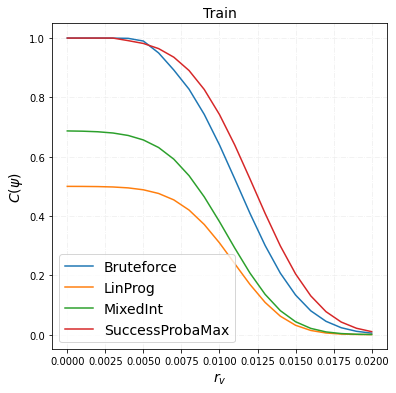

In [347]:
methods = ['Bruteforce', 'LinProg', 'MixedInt', 'SuccessProbaMax']
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_vs_train,
        res_v_2d_train[m],
        label=m
    )
    
plt.xlabel('$r_v$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

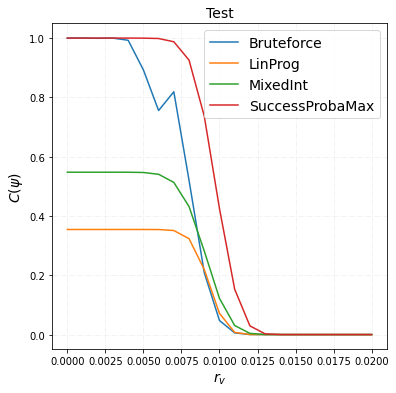

In [348]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_vs_test,
        res_v_2d_test[m],
        label=m
    )
    
plt.xlabel('$r_v$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [61]:
### Define r_c (success region) with AB test interpretation
r_c_pct_range = np.arange(-0.03, 0.025, 0.005)
R_cs_train = r_c_pct_range ### rel diff
R_cs_test = r_c_pct_range ### rel diff

methods = ['Bruteforce', 'LinProg', 'MixedInt', 'SuccessProbaMax']
res_c_2d_train = {i:np.zeros_like(R_cs_train) for i in methods}
res_c_2d_test = {i:np.zeros_like(R_cs_test) for i in methods}

In [62]:
for i in tqdm(range(len(R_cs_train))):
    hard_bf_alloc = hard_bruteforce_2d_v2(all_hard_allocs, mu_0_train, cov_0_train, total_v_ref_train, R_cs_train[i])
    res_c_2d_train['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_train, cov_0_train, total_v_ref_train, R_cs_train[i])
    res_c_2d_test['Bruteforce'][i] = evaluate_2d_v2(hard_bf_alloc, mu_0_test, cov_0_test, total_v_ref_test, R_cs_test[i])
    
    greedy_soft_alloc = greedy_2d(mu_0_v_train, mu_0_c_train, R_cs_train[i], nbucket, npol)
    res_c_2d_train['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_train, cov_0_train, total_v_ref_train, R_cs_train[i])
    res_c_2d_test['LinProg'][i] = evaluate_2d_v2(greedy_soft_alloc, mu_0_test, cov_0_test, total_v_ref_test, R_cs_train[i])
    
    greedy_mi_alloc = greedy_2d(mu_0_v_train, mu_0_c_train, R_cs_train[i], nbucket, npol, soft=0)
    res_c_2d_train['MixedInt'][i] = evaluate_2d_v2(greedy_mi_alloc, mu_0_train, cov_0_train, total_v_ref_train, R_cs_train[i])
    res_c_2d_test['MixedInt'][i] = evaluate_2d_v2(greedy_mi_alloc, mu_0_test, cov_0_test, total_v_ref_test, R_cs_train[i])
    
    spm_alloc = optimize_2d_my_v4(cov_0_train, mu_0_train, total_v_ref_train, R_cs_train[i], psi_0s, n_steps=5000000, eta = 0.0001)
    res_c_2d_train['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_train, cov_0_train, total_v_ref_train, R_cs_train[i])
    res_c_2d_test['SuccessProbaMax'][i] = evaluate_2d_v2(spm_alloc, mu_0_test, cov_0_test, total_v_ref_test, R_cs_train[i])

100%|██████████| 11/11 [05:26<00:00, 29.68s/it]


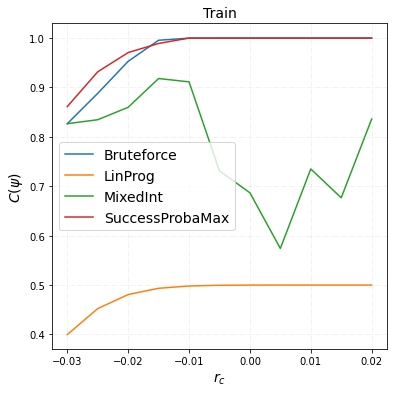

In [349]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_cs_train,
        res_c_2d_train[m],
        label=m
    )
    
plt.xlabel('$r_c$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

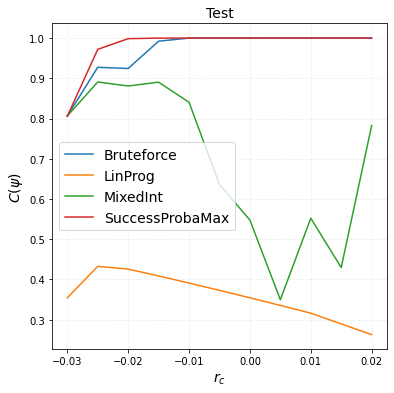

In [350]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:
    plt.plot(
        R_cs_test,
        res_c_2d_test[m],
        label=m
    )
    
plt.xlabel('$r_c$', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [465]:
def df_prepro_h(df, policies_col, y_col, partition_col, groups, n_bs):
    if type(groups) == int:
        df['groups'] = pd.qcut(df[partition_col], groups, labels=False, duplicates='drop')
    elif type(groups) == list:
        df['groups'] = pd.cut(df[partition_col], bins=groups, labels=False, include_lowest=1)#.astype(int)
    
    df_grouped = df[[policies_col,y_col,'groups']].groupby(['groups', policies_col]).apply(lambda x: agg_sum_and_bs_sum2(x, [y_col], n_bs)).reset_index()
    print(df_grouped.columns)
    
    # counts = df[['treatment','groups']].groupby(['groups', 'treatment']).size().reset_index(name='counts')
    # df_grouped[y_col+'_w'] = df_grouped[y_col] / (counts_train.counts / len(cu2_df))
    # df_grouped[y_col+'_bs_w'] = df_grouped[y_col+'_bs'] / (counts_train.counts / len(cu2_df))
    
    return df_grouped


def agg_sum_and_bs_sum2(group_df, colnames, n_bs=30, random_state=23409834):
    '''
    Aggregation function that performs summation of original values along with summations of the bootstraps (by sampling with replacements).
    '''
    bootstrap_pops = np.random.choice(len(group_df), size=(len(group_df), n_bs), replace=True)
    col_sums = {}

    for colname in colnames:
        vals = group_df[colname].values
        bs_sums = np.sum(vals[bootstrap_pops], axis=0)
        col_sums[colname+"_bs"] = bs_sums
        
    simple_sums = group_df[colnames].sum()
    col_sums.update(simple_sums)

    return pd.Series(col_sums)

In [25]:
h_df = pd.read_csv('../../../../../uplift_experiments/hillstrom_data.csv')

In [1169]:
h_df

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
6634,1,3) $200 - $350,291.76,1,1,Urban,0,Phone,Womens E-Mail,0,0,0.0
60931,2,3) $200 - $350,309.05,1,0,Urban,1,Multichannel,No E-Mail,0,0,0.0
26580,4,4) $350 - $500,458.73,1,0,Urban,0,Phone,No E-Mail,1,0,0.0
48188,3,4) $350 - $500,412.53,1,0,Urban,0,Phone,No E-Mail,0,0,0.0
46233,1,"7) $1,000 +",1240.41,0,1,Surburban,1,Web,No E-Mail,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31570,1,3) $200 - $350,257.68,1,1,Surburban,1,Phone,Mens E-Mail,1,0,0.0
21989,4,3) $200 - $350,224.11,1,0,Surburban,0,Web,No E-Mail,0,0,0.0
48327,7,1) $0 - $100,67.71,0,1,Surburban,0,Web,Mens E-Mail,0,0,0.0
40023,2,4) $350 - $500,449.92,1,0,Urban,0,Multichannel,Mens E-Mail,0,0,0.0


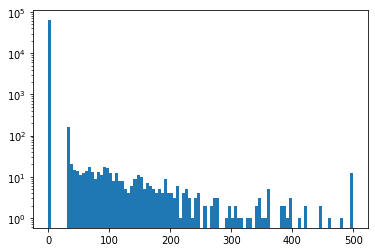

In [48]:
plt.hist(h_df.spend, bins=100, log=1)
plt.show()

recency Y corr:  -0.07476533979106369 -0.016348232261341435


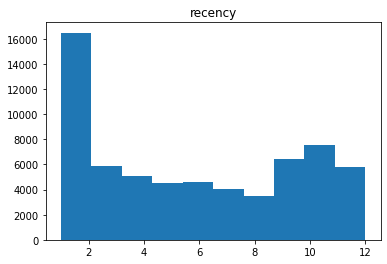

history Y corr:  0.0651533593508418 0.021729000144139907


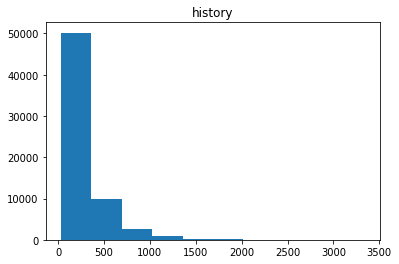

In [1352]:
for i in ['recency', 'history']:
    print(i, 'Y corr: ', np.corrcoef(h_df.visit, h_df[i])[0][1], np.corrcoef(h_df.spend, h_df[i])[0][1])
    plt.figure()
    plt.hist(h_df[i], bins=10)
    plt.title(i)
    plt.show()

In [22]:
h_df['segment'][h_df['segment']=='Womens E-Mail'] = 'w'
h_df['segment'][h_df['segment']=='Mens E-Mail'] = 'm'
h_df['segment'][h_df['segment']=='No E-Mail'] = 'ref'

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

In [23]:
h_df = h_df.sample(frac=1)
ind_train = int(len(h_df)/2.)

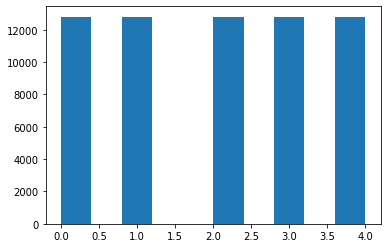

In [1364]:
plt.hist(pd.qcut(h_df['history'], 5, labels=False, duplicates='drop'))
plt.show()

In [622]:
params = {
    'policies_col': 'segment',
    # 'y_col': 'visit',
    # 'y_col': 'conversion',
    'y_col': 'spend',
    # 'partition_col': 'history',
    'partition_col': 'recency',
    'nb_groups_theo': 15,
    'n_bs': 100,
}

In [623]:
# h_df.history

In [624]:
h_df_grouped_train = df_prepro_h(h_df[:ind_train], params['policies_col'], params['y_col'], params['partition_col'], params['nb_groups_theo'], params['n_bs'])
_, bins_train = pd.qcut(h_df[:ind_train][params['partition_col']], params['nb_groups_theo'], retbins=True, labels=False, duplicates='drop')
h_df_grouped_test = df_prepro_h(h_df[ind_train:], params['policies_col'], params['y_col'], params['partition_col'], list(bins_train), params['n_bs'])

h_df_grouped_train[params['y_col']+'_bs_mean'] = h_df_grouped_train[params['y_col']+'_bs'].apply(lambda x:np.mean(x))
h_df_grouped_train[params['y_col']+'_bs_var'] = h_df_grouped_train[params['y_col']+'_bs'].apply(lambda x:np.var(x))

h_df_grouped_test[params['y_col']+'_bs_mean'] = h_df_grouped_test[params['y_col']+'_bs'].apply(lambda x:np.mean(x))
h_df_grouped_test[params['y_col']+'_bs_var'] = h_df_grouped_test[params['y_col']+'_bs'].apply(lambda x:np.var(x))

h_mu_0_train = np.array([h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs_mean'].values for i in h_df_grouped_train.groups.unique()])
h_Sigma_0_train = np.array([h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs_var'].values for i in h_df_grouped_train.groups.unique()])

h_mu_0_test = np.array([h_df_grouped_test[h_df_grouped_test.groups==i][params['y_col']+'_bs_mean'].values for i in h_df_grouped_test.groups.unique()])
h_Sigma_0_test = np.array([h_df_grouped_test[h_df_grouped_test.groups==i][params['y_col']+'_bs_var'].values for i in h_df_grouped_test.groups.unique()])

h_df_nbucket = len(h_df_grouped_test.groups.unique())
h_df_npol = len(h_df_grouped_train[params['policies_col']].unique())

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Index(['groups', 'segment', 'spend_bs', 'spend'], dtype='object')
Index(['groups', 'segment', 'spend_bs', 'spend'], dtype='object')


In [625]:
h_df_nbucket, h_df_npol

(11, 3)

In [626]:
# h_df_grouped_train

LinAlgError: singular matrix

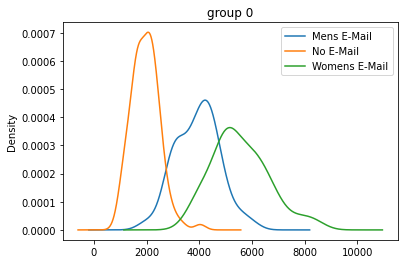

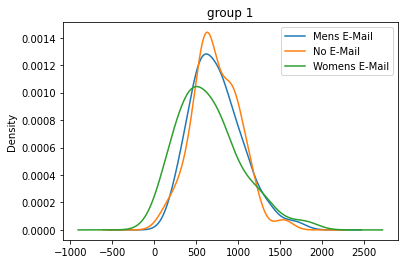

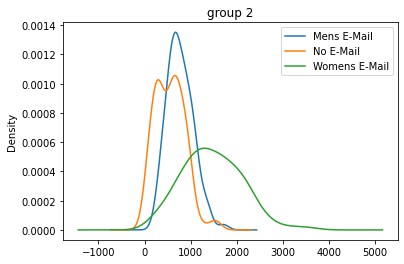

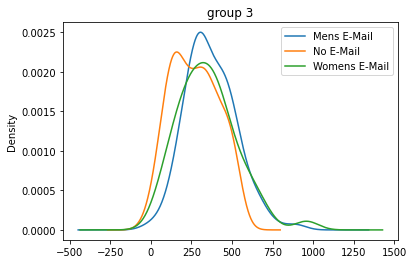

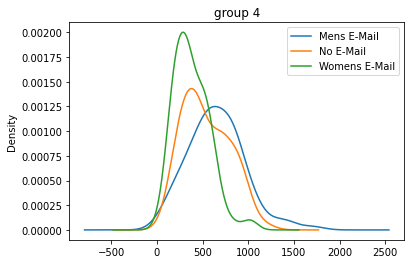

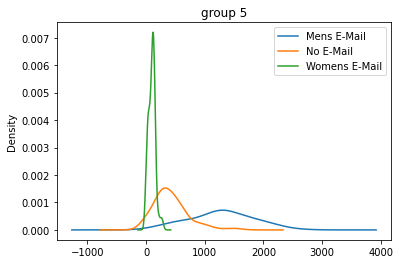

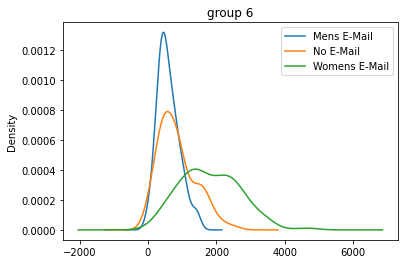

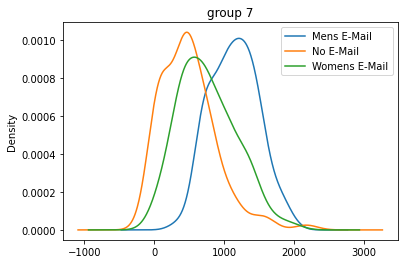

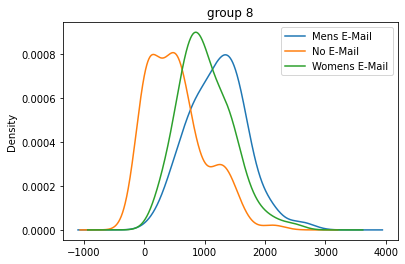

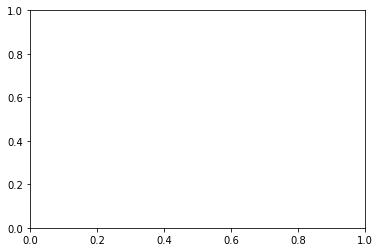

In [627]:
for i in h_df_grouped_train.groups.unique():
    pd.DataFrame(
        np.array(h_df_grouped_train[h_df_grouped_train.groups==i][params['y_col']+'_bs'].tolist()).T, 
        columns=list(h_df_grouped_train[params['policies_col']].unique())
    ).plot(kind='density', title='group '+str(i))

In [628]:
h_mu_0_train

array([[3932.4985, 1958.9064, 5559.8557],
       [ 745.7327,  735.0373,  658.0425],
       [ 772.6853,  550.952 , 1466.5611],
       [ 370.253 ,  270.4397,  350.4848],
       [ 649.6163,  540.6638,  380.8531],
       [1278.2061,  421.2195,   98.9396],
       [ 594.9376,  842.4332, 1818.3693],
       [1144.4631,  497.2452,  762.1694],
       [1211.9612,  532.6056, 1012.5484],
       [   0.    ,  278.9678,  585.3318],
       [ 998.682 ,  124.8377,  116.4002]])

In [629]:
h_Sigma_0_train

array([[ 674350.33764675,  275038.24529904, 1157313.26434851],
       [  91565.18096571,   76333.25562171,  144772.63901875],
       [  76603.00192091,   99827.701542  ,  408083.85339379],
       [  23673.517113  ,   20458.49511691,   32990.77846696],
       [  93698.85681131,   64416.56859756,   36829.63519139],
       [ 294207.09853379,   86358.90988075,    3296.90906984],
       [  97926.68289624,  288057.98302576,  727746.42540651],
       [ 112522.27185139,  158093.39081496,  165431.47645964],
       [ 221794.40102256,  224009.90660664,  190681.00690744],
       [      0.        ,   53472.30450716,   95263.41621076],
       [ 342236.772896  ,   13404.38584771,    8983.16718396]])

In [630]:
h_df_ref_col = 0

h_total_y_ref = np.sum(np.array(h_mu_0_train)[:,h_df_ref_col])

h_df_r_y = 1. * h_total_y_ref

In [631]:
methods = ['greedy_soft', 'SPM']
h_df_allocs_dict = {}

### greedy allocation
h_df_allocs_dict['greedy'] = greedy_1d(h_mu_0_train)

### initial allocation to start SPM from 
h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket)
# h_df_psi_0 = h_df_allocs_dict['greedy']

h_df_allocs_dict['SPM'] = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_r_y, h_df_psi_0, n_steps=100000, eta = 0.1))

In [632]:
h_df_allocs_dict['greedy']

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [633]:
h_df_allocs_dict['SPM']

array([[0.        , 0.        , 1.        ],
       [0.6897303 , 0.31026977, 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ]], dtype=float32)

In [634]:
evaluate_1d_v2(h_df_allocs_dict['greedy'], h_mu_0_train, h_Sigma_0_train, h_df_r_y), evaluate_1d_v2(h_df_allocs_dict['greedy'], h_mu_0_test, h_Sigma_0_test, h_df_r_y)

(0.9856070528832299, 0.9622057423035211)

In [635]:
evaluate_1d_v2(h_df_allocs_dict['SPM'], h_mu_0_train, h_Sigma_0_train, h_df_r_y), evaluate_1d_v2(h_df_allocs_dict['SPM'], h_mu_0_test, h_Sigma_0_test, h_df_r_y)

(0.9855957732142752, 0.9197057662173667)

In [636]:
### for hard bruteforce
h_df_candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=h_df_npol)) if sum(comb) == 1]
h_df_all_hard_allocs = list(itertools.product(h_df_candidates, repeat=h_df_nbucket))

### greedy allocation
h_df_greedy_alloc = greedy_1d(h_mu_0_train)

In [637]:
### Define r_y (success region) with AB test interpretation
h_df_R_ys = h_total_y_ref * (1 + np.arange(0, 0.3, 0.01))

methods = ['greedy', 'SPM']
h_df_res_y_1d = {i:np.zeros_like(h_df_R_ys) for i in methods}

In [638]:
for i in tqdm(range(len(h_df_R_ys))):
    
    # h_df_hard_bf_alloc = hard_bruteforce_1d(y_bs, all_hard_allocs, Rs[i])
    # h_df_res_y_1d['hard_bf'][i] = evaluate_1d(y_bs, hard_bf_alloc, Rs[i])
    
    h_df_res_y_1d['greedy'][i] = evaluate_1d_v2(h_df_greedy_alloc, h_mu_0_train, h_Sigma_0_train, h_df_R_ys[i])
    
    ### initial allocation to start SPM from 
    h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    
    h_df_spm_alloc = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_R_ys[i], h_df_psi_0, n_steps=10000, eta = 0.01))
    h_df_res_y_1d['SPM'][i] = evaluate_1d_v2(h_df_spm_alloc, h_mu_0_train, h_Sigma_0_train, h_df_R_ys[i])

100%|██████████| 30/30 [00:02<00:00, 12.98it/s]


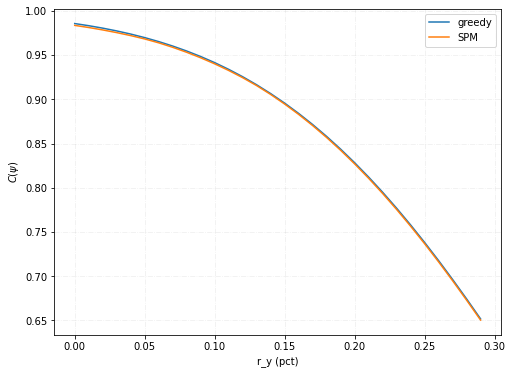

In [639]:
plt.figure(figsize=(8,6))

for m in h_df_res_y_1d.keys():
    plt.plot(
        (h_df_R_ys / h_total_y_ref) - 1,
        h_df_res_y_1d[m],
        label=m
    )
    
plt.xlabel('r_y (pct)')
plt.ylabel('$C(\psi)$')
plt.grid(alpha=0.2, ls="-.")
# plt.title('psi_0 = '+str(psi_0))
plt.legend()
plt.show()

In [614]:
for i in tqdm(range(len(h_df_R_ys))):
    
    # h_df_hard_bf_alloc = hard_bruteforce_1d(y_bs, all_hard_allocs, Rs[i])
    # h_df_res_y_1d['hard_bf'][i] = evaluate_1d(y_bs, hard_bf_alloc, Rs[i])
    
    h_df_res_y_1d['greedy'][i] = evaluate_1d_v2(h_df_greedy_alloc, h_mu_0_test, h_Sigma_0_test, h_df_R_ys[i])
    
    ### initial allocation to start SPM from 
    h_df_psi_0 = np.array([[1./h_df_npol]*h_df_npol]*h_df_nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    
    h_df_spm_alloc = np.array(optimize_1d(h_Sigma_0_train, h_mu_0_train, h_df_R_ys[i], h_df_psi_0, n_steps=10000, eta = 0.01))
    h_df_res_y_1d['SPM'][i] = evaluate_1d_v2(h_df_spm_alloc, h_mu_0_test, h_Sigma_0_test, h_df_R_ys[i])

100%|██████████| 30/30 [00:01<00:00, 17.79it/s]


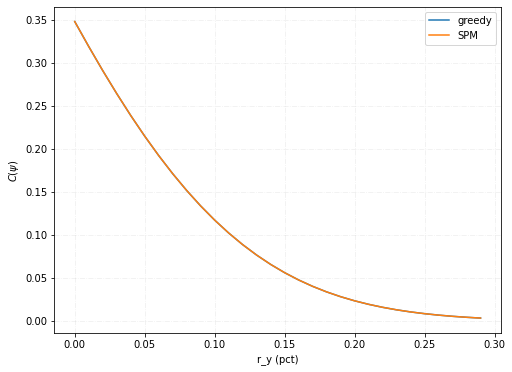

In [615]:
plt.figure(figsize=(8,6))

for m in h_df_res_y_1d.keys():
    plt.plot(
        (h_df_R_ys / h_total_y_ref) - 1,
        h_df_res_y_1d[m],
        label=m
    )
    
plt.xlabel('r_y (pct)')
plt.ylabel('$C(\psi)$')
plt.grid(alpha=0.2, ls="-.")
# plt.title('psi_0 = '+str(psi_0))
plt.legend()
plt.show()